In [37]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [38]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [39]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [40]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [41]:
# Declare a Base using `automap_base()`
Base=automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

C:\Users\mcayt\AppData\Local\Temp\ipykernel_31144\3212801575.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [42]:
# View all of the classes mapped
print(Base.classes.keys())

['station', 'measurement']


In [43]:
# Assign the measurement class to a variable called `Measurement` and the station class to a variable called `Station`
Measurement=Base.classes.measurement
Station=Base.classes.station

In [44]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [45]:
# Find the most recent date in the data set.
query = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
query

('2017-08-23',)

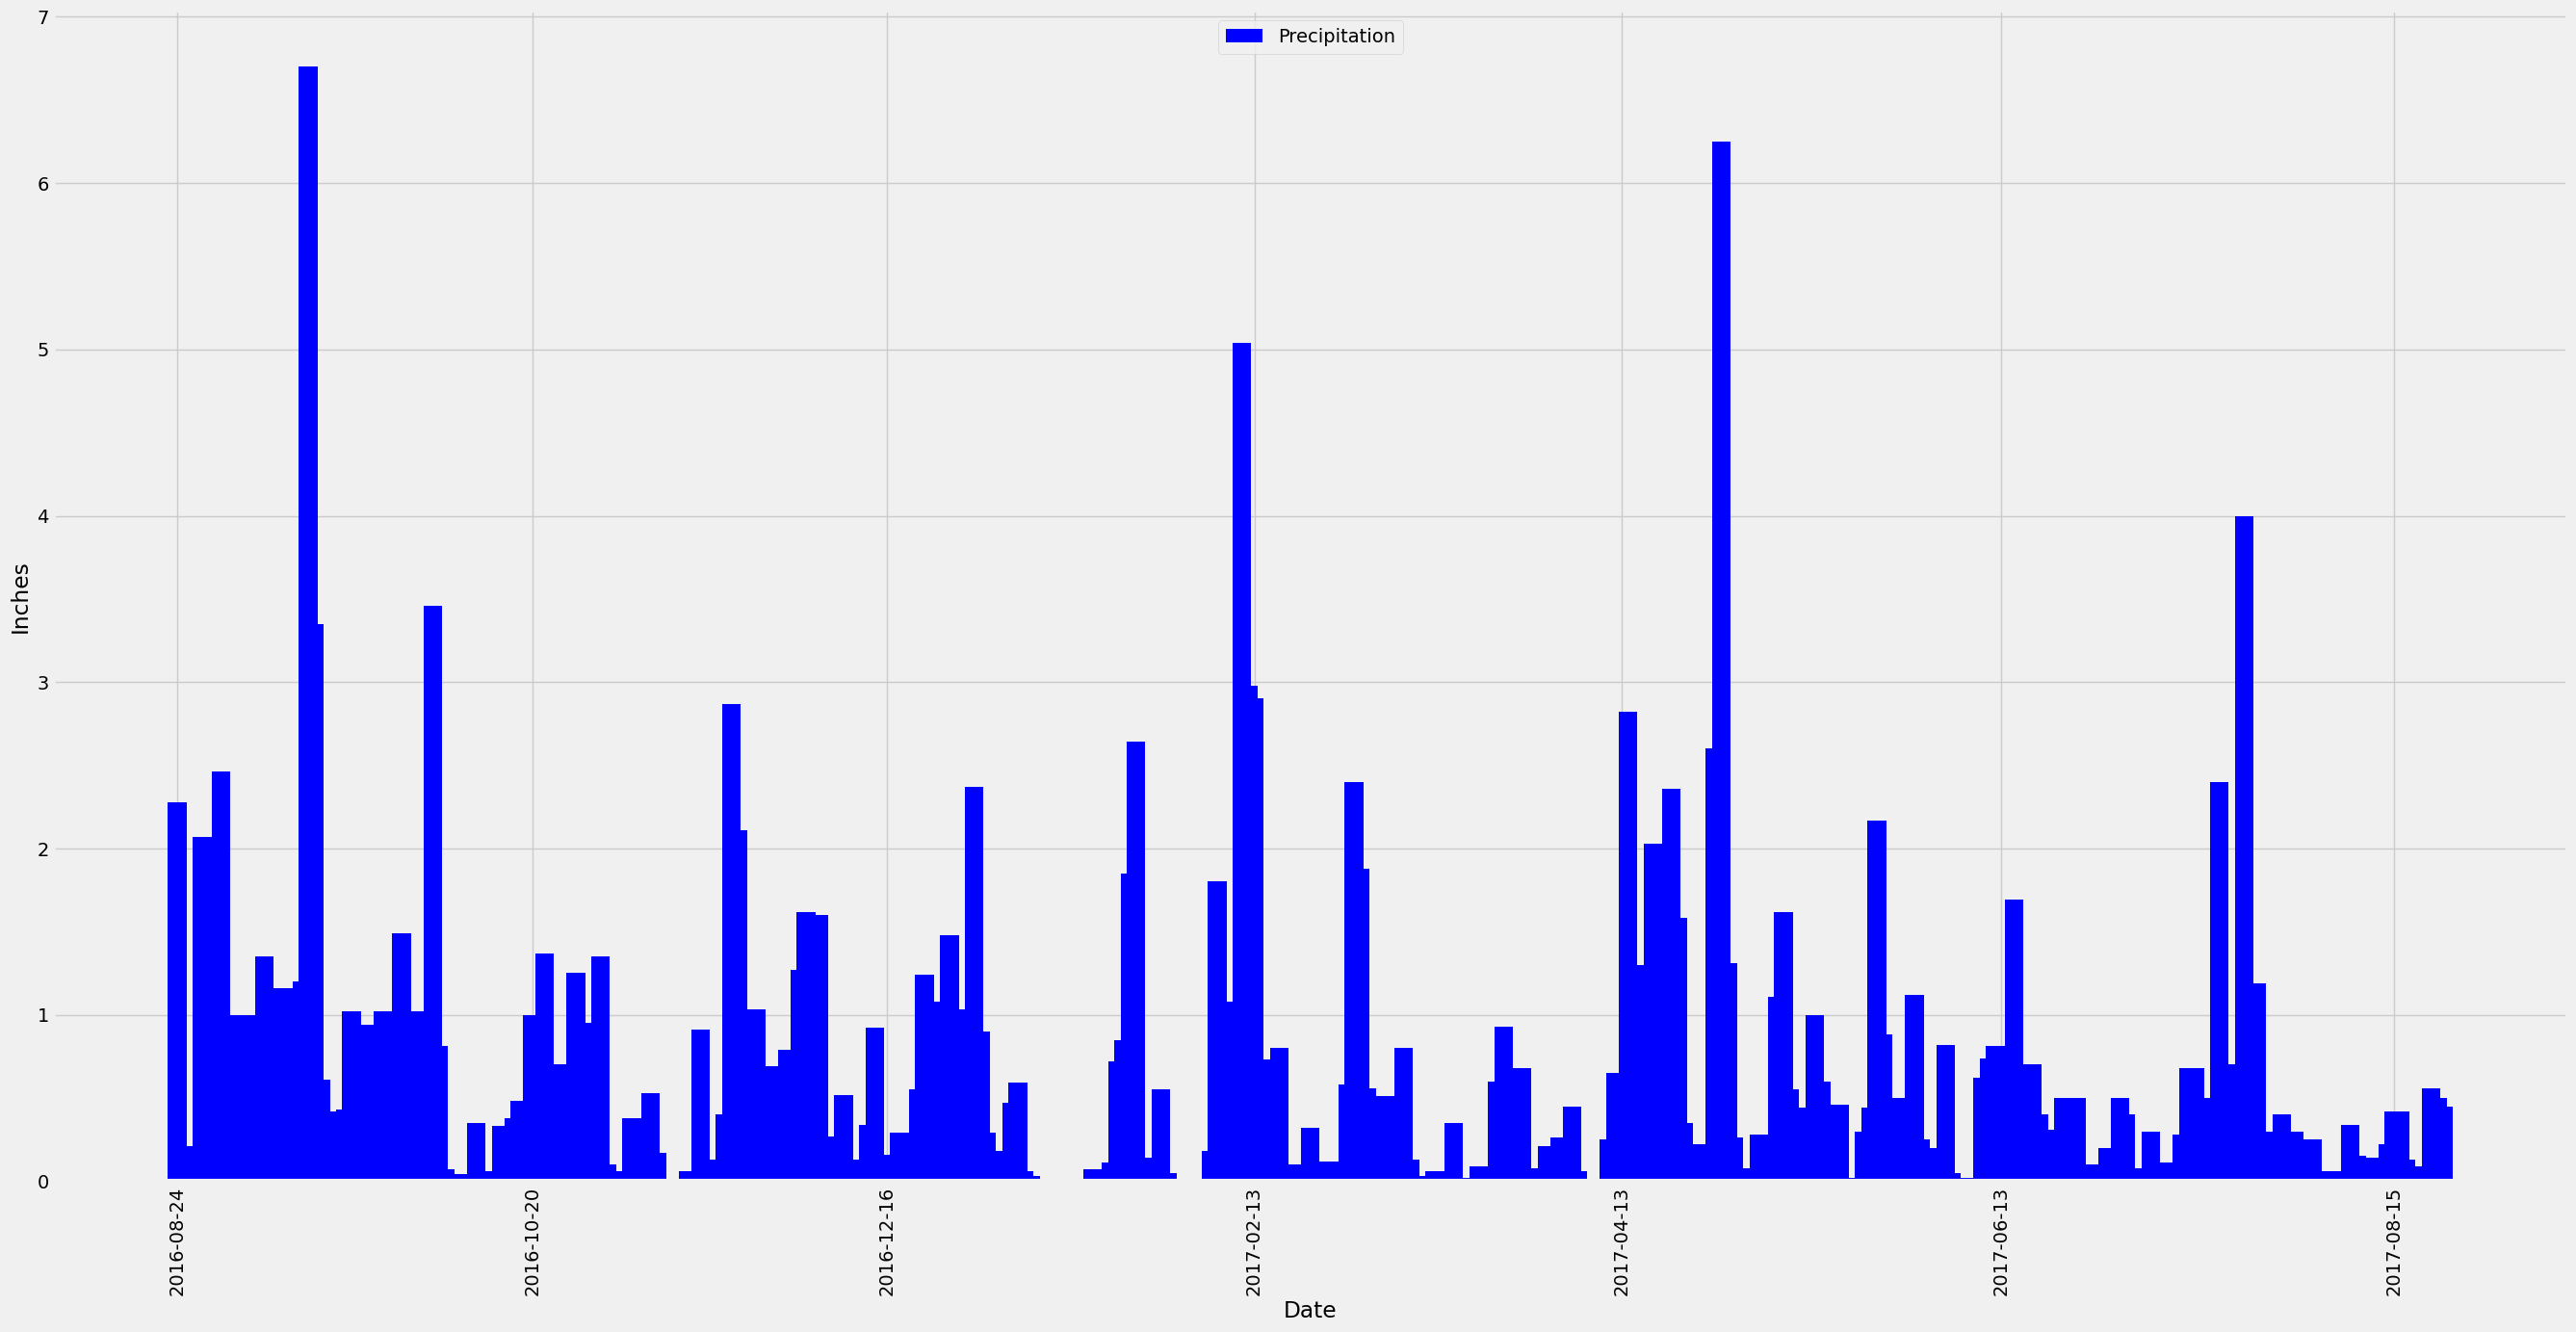

In [46]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. Starting from the most recent data point in the database.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_12mo=pd.DataFrame(query, columns=['date', 'precipitation'])

# Sort the dataframe by date
prcp_12mo.sort_values(by=['date'], ascending = True, inplace=True)
dates = np.array(prcp_12mo['date'])

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(30,15))
plt.bar(prcp_12mo['date'], prcp_12mo['precipitation'], width=3, color='b', align="center")
plt.grid(True, which='both', axis='both', )
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(["Precipitation"], loc="upper center")

# ChatGPT assisted with array slicing 'dates[::365]' to reduce the number of ticks per classmate recommendation.
plt.xticks(dates[::365], rotation=90)
plt.show()

In [47]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_12mo.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [48]:
# Design a query to calculate the total number of stations in the dataset
query = session.query(Station.station).count()

In [49]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_activity
highest_activity = station_activity[0][0]
highest_activity

'USC00519281'

In [50]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
most_active

[(54.0, 85.0, 71.66378066378067)]

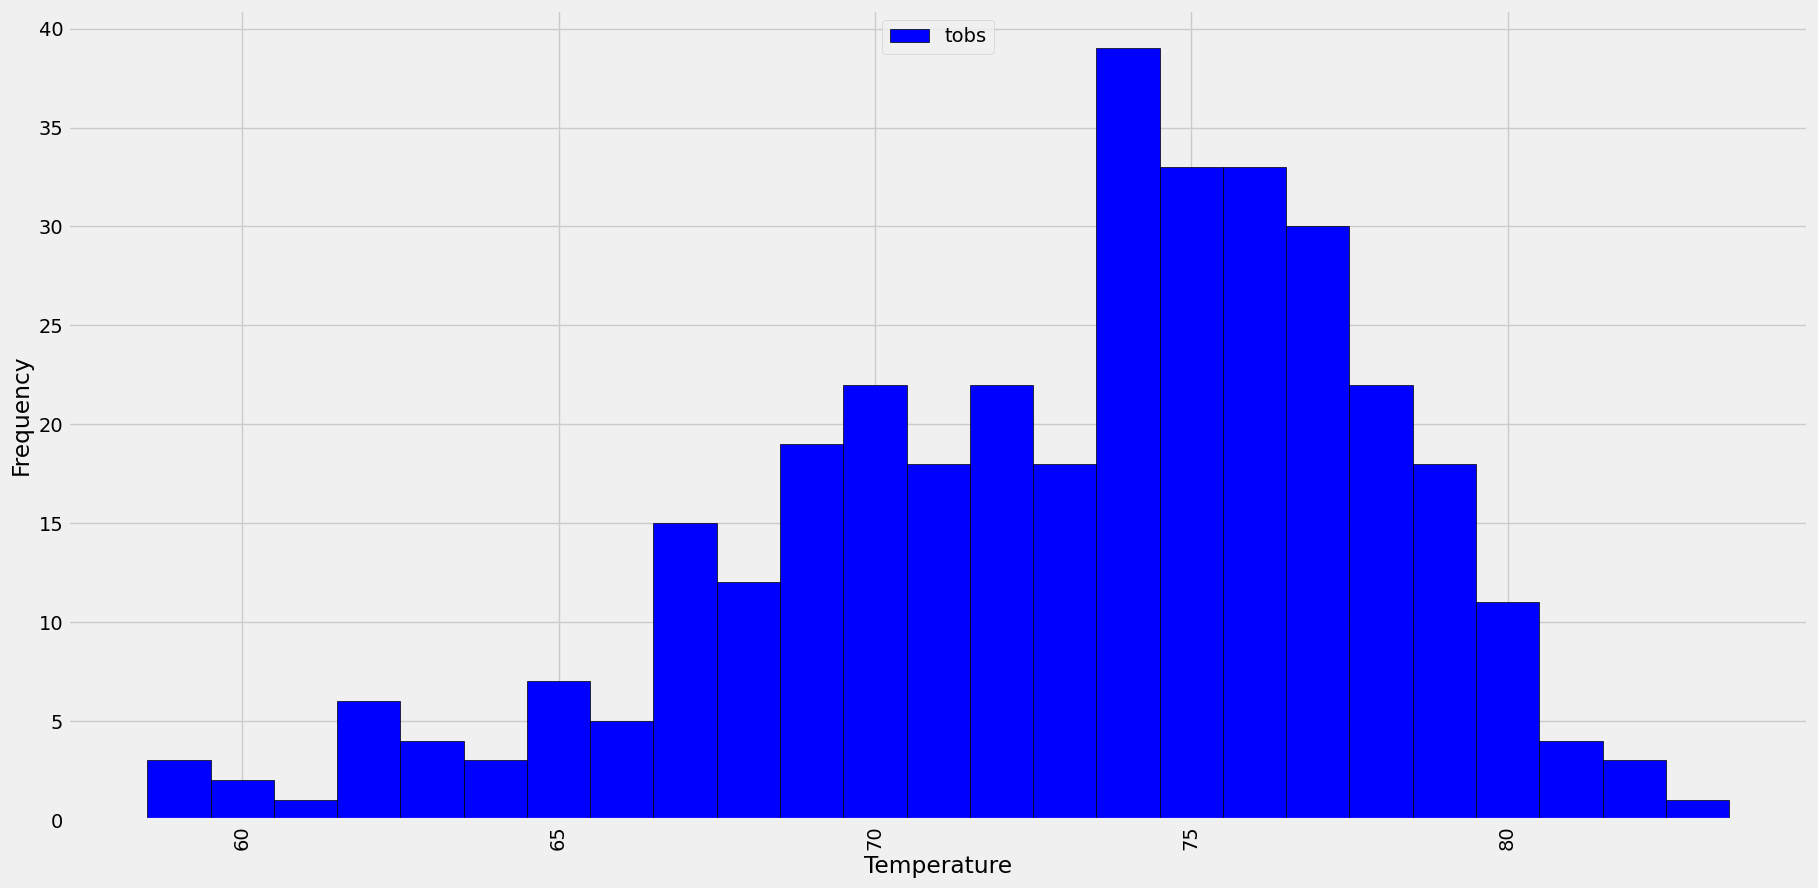

In [51]:
# Using the most active station ID, query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d')
most_recent_date

one_year_ago = most_recent_date - dt.timedelta(days=365)

# Data frequency
most_active_temp_freq = session.query(Measurement.tobs).filter(Measurement.date >= one_year_ago).filter(Measurement.station == highest_activity).all()
most_active_temp_freq

# TOBS grouped by frequency
most_active_freq=pd.DataFrame(most_active_temp_freq, columns=['tobs'])
most_active_freq.head()
tobs_freq = pd.DataFrame(most_active_freq.groupby(['tobs']).size(), columns=['frequency']) 
tobs_freq

# Data date
most_active_temp_date = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= one_year_ago).filter(Measurement.station == highest_activity).all()
most_active_temp_date

# TOBS grouped by month
most_active_12mo=pd.DataFrame(most_active_temp_date, columns=['date', 'tobs'])
most_active_12mo['date'] = pd.to_datetime(most_active_12mo['date'])
most_active_12mo['month'] = most_active_12mo['date'].dt.month
most_active_12mo_grouped = most_active_12mo.groupby('month')['tobs'].mean().reset_index()
most_active_12mo_grouped.head(12)

# Sort the dataframe by date
most_active_12mo.sort_values(by=['date'])
most_active_12mo.head()

#Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(20,10))
plt.bar(tobs_freq.index, tobs_freq['frequency'], width=1, color='b', align="center", edgecolor='black')
plt.grid(True, which='both', axis='both', )
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(["tobs"], loc="upper center")
plt.xticks(rotation=90)
plt.show()

# Close Session

In [52]:
# Close Session
session.close()